In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [3]:
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0

        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

        # return label, image data tensor and target tensor
        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass

    pass

In [4]:
mnist_dataset=MnistDataset("/content/drive/MyDrive/GAN/mnist_train.csv")

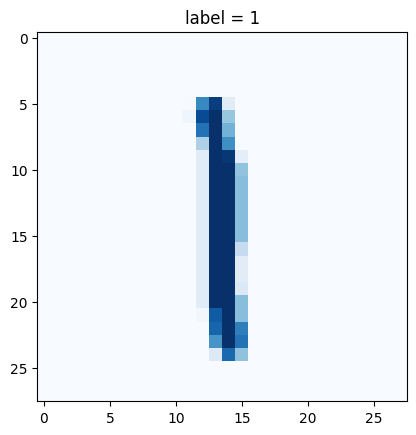

In [8]:
mnist_dataset.plot_image(14)

In [11]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1) # 0에서 size-1 까지의 숫자중에 랜덤하게 한 숫자를 뽑음
    label_tensor[random_idx] = 1.0 # 위에서 뽑은 임의의 정수의 인덱스를 1로 설정함
    return label_tensor

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784+10, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )


        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, image_tensor, label_tensor):
      # 레이블 텐서 결합
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)


    def train(self, inputs, label_tensor, targets):

        outputs = self.forward(inputs, label_tensor)


        loss = self.loss_function(outputs, targets)


        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass


        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

In [12]:
D = Discriminator()

for label, image_data_tensor, label_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image(784), generate_random_one_hot(10), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000


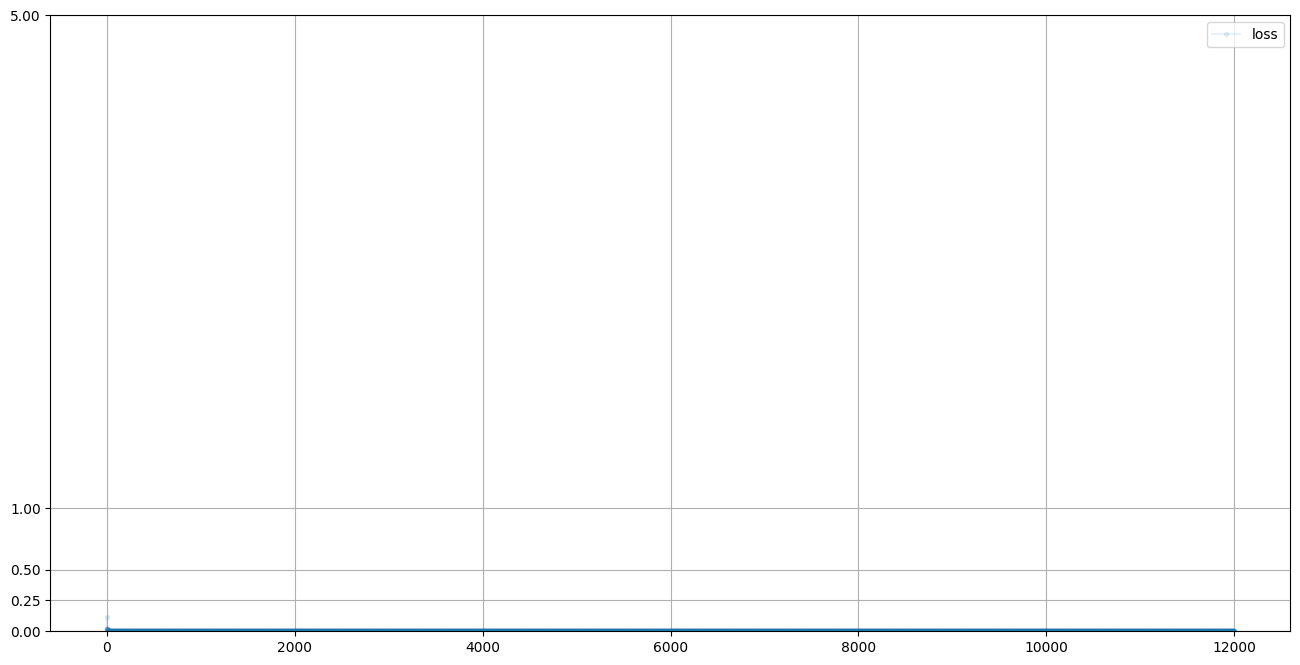

In [13]:
D.plot_progress()

In [14]:
for i in range(4):
  label, image_data_tensor, label_tensor = mnist_dataset[random.randint(0,60000)]
  print( D.forward( image_data_tensor, label_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(784), generate_random_one_hot(10) ).item() )
  pass

1.0
1.0
1.0
1.0
8.508593135614362e-12
9.197843008068585e-12
7.921598273175068e-12
9.181191397422683e-12


In [16]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0;
        self.progress = []

        pass


    def forward(self, seed_tensor, label_tensor):
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)


    def train(self, D, inputs, label_tensor, targets):
        g_output = self.forward(inputs, label_tensor)

        d_output = D.forward(g_output, label_tensor)

        loss = D.loss_function(d_output, targets)


        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass


        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

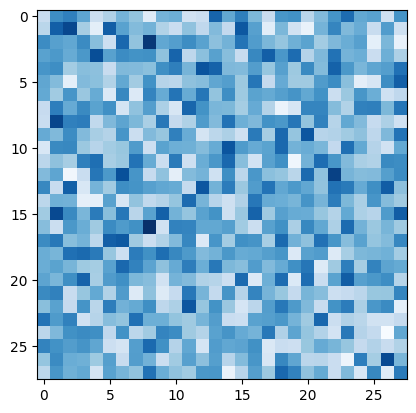

In [17]:
G = Generator()

output = G.forward(generate_random_seed(100), generate_random_one_hot(10))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

In [18]:
epochs = 12

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  for label, image_data_tensor, label_tensor in mnist_dataset:

    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    random_label = generate_random_one_hot(10)
    D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))
    random_label = generate_random_one_hot(10)
    G.train(D, generate_random_seed(100), random_label, torch.FloatTensor([1.0]))

    pass

  pass

epoch =  1
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  2
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  3
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
epoch =  4
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000
counter =  540000
counter =  550000
counter =  560000
counter =  570000
counter =  580000
counter =  590000
counter =  600000
epoch =  5
counter =  610000
counter =  620000
counter =  630000
counter =  640000
counter =

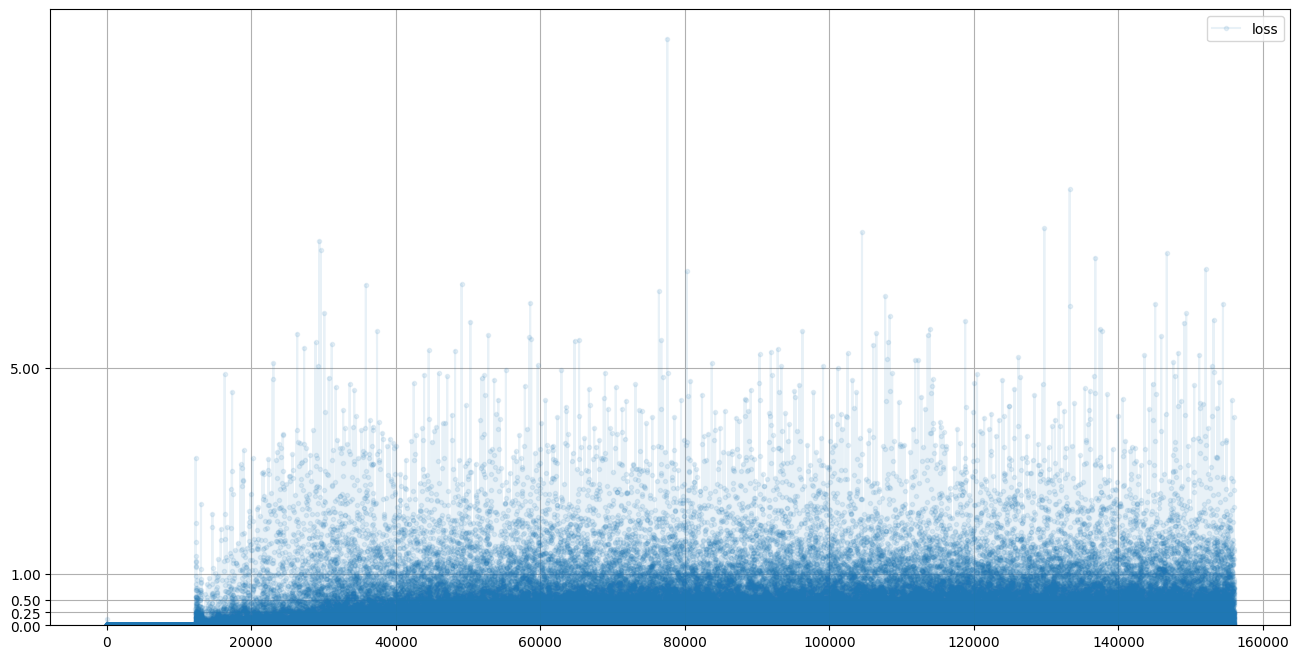

In [19]:
D.plot_progress()

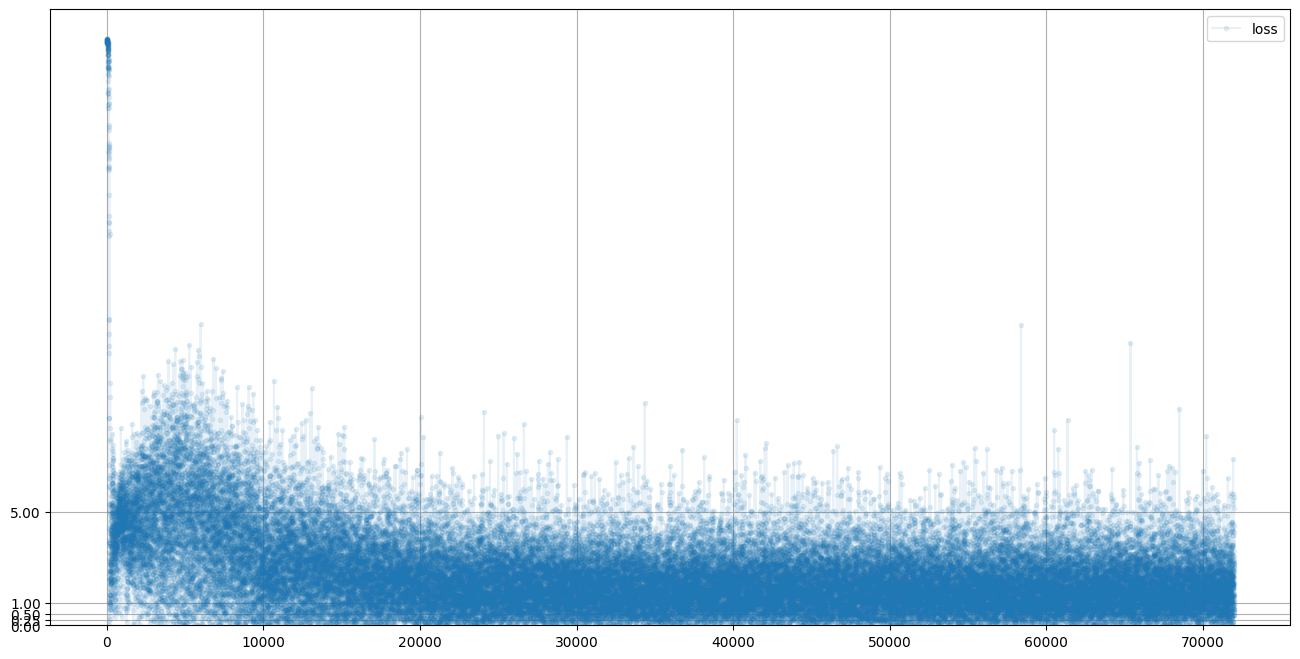

In [20]:
G.plot_progress()

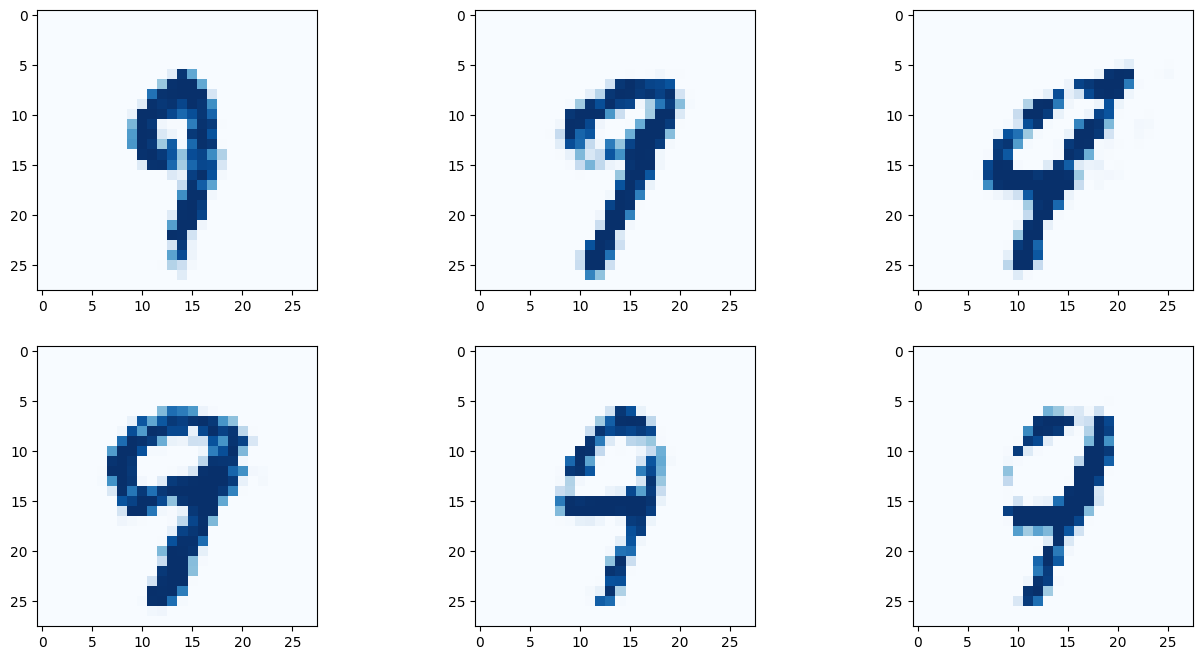

In [21]:
G.plot_images(9)

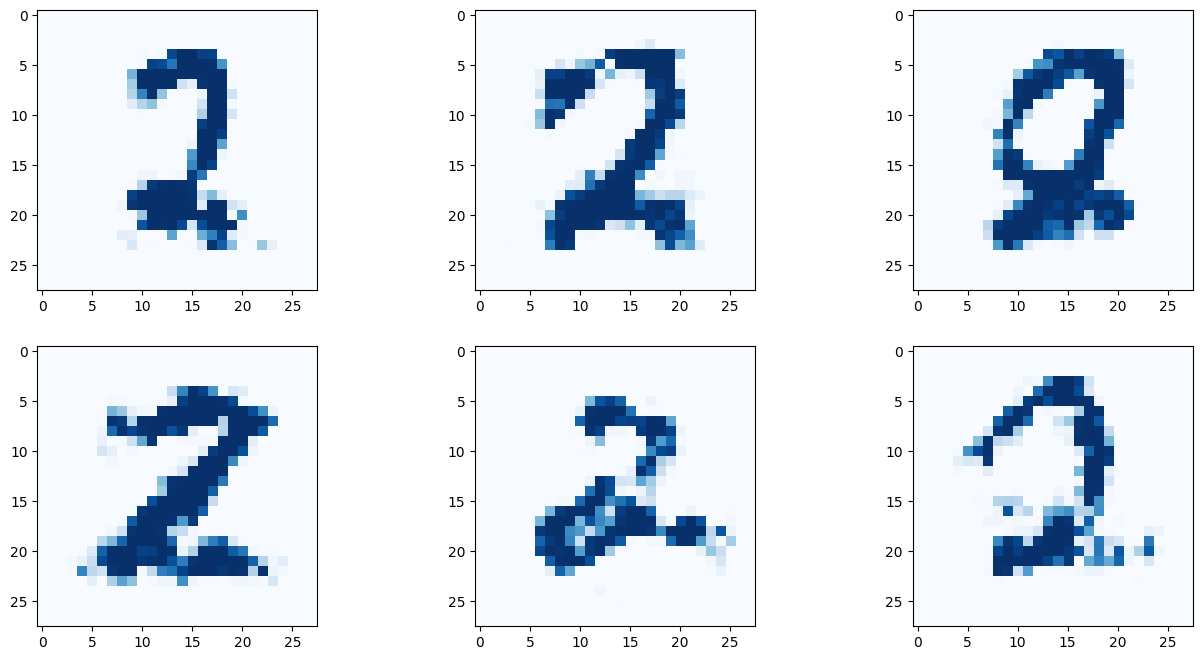

In [22]:
G.plot_images(2)

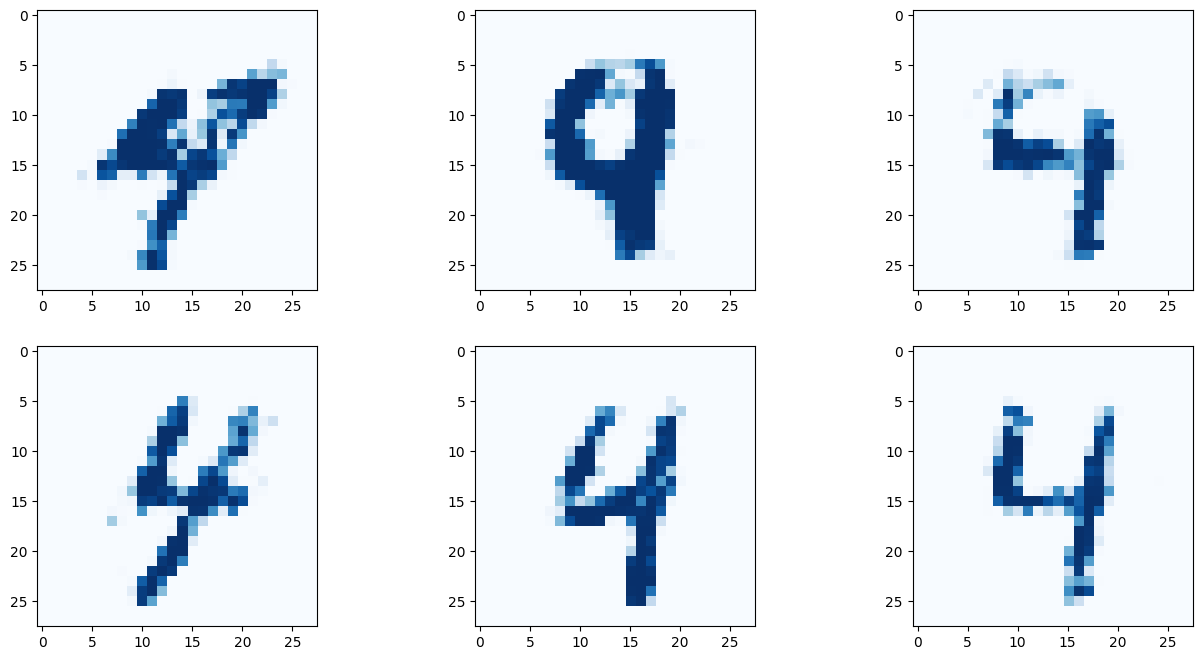

In [23]:
G.plot_images(4)